In [2]:
import numpy as np
import cv2
import pandas as pd
import PIL
import utm
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import os

In [5]:
subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos

import pickle
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

videos = load_obj('data_wo_segments')

In [2]:
video_name = 'Help'
data = pd.read_fwf('data/head_tracking_data/Subject_6/' + video_name + '.txt', header=None)

data.columns = ['latitude', 'longitude']

cap = cv2.VideoCapture('data/video_files/' + video_name + '.mp4')

In [29]:
# joins together two columns
for video_id in video_list:
    for subj_id in subject_list:
        videos[video_id][subj_id]['z'] = videos[video_id][subj_id]['s_bin_zone'].apply(str) + videos[video_id][subj_id]['s_bin_band'].apply(str)

In [33]:
# count unique tiles
video_stat = {}
for video_id in video_list:
    subj_ = {}
    for subj_id in subject_list:
        subj_[subj_id] = videos[video_id][subj_id]['z'].value_counts()
    video_stat[video_id] = subj_

In [72]:
# dynamicity score v2? 
video_score = {}
for video_id in video_list:
    subj_ = {}
    for subj_id in subject_list:
        subj_[subj_id] = np.std(video_stat[video_id][subj_id]) * (len(video_stat[video_id][subj_id])/16)
    video_score[video_id] = subj_

In [86]:
# pd.DataFrame.from_dict(video_score).mean(axis=0).sort_values(ascending=False)

In [3]:
def start_end_point(lat, lon):
    start = [lon - 55, lat + 50]
    end = [lon + 55, lat - 50]
    if start[0] > 180:
        start[0] = start[0] - 360
    elif start[0] < -180:
        start[0] = start[0] + 360
    if start[1] > 80:
        start[1] = start[1] - 160
    elif start[1] < - 80:
        start[1] = start[1] + 160

    if end[0] > 180:
        end[0] = end[0] - 360
    elif end[0] < -180:
        end[0] = end[0] + 360
    if end[1] > 80:
        end[1] = end[1] - 160
    elif end[1] < - 80:
        end[1] = end[1] + 160

    return(start, end)

starting_points = []
ending_points = []

# Determine top left and bottom right UTM coordinates of the viewport
for i in range(len(data)):
    start, end = start_end_point(data.iloc[i]['latitude'], data.iloc[i]['longitude'])
    
    start_utm = utm.from_latlon(start[1], start[0])
    starting_points.append(start_utm[2:])
    
    end_utm = utm.from_latlon(end[1], end[0])
    ending_points.append(end_utm[2:])

starting_zones = pd.DataFrame(starting_points)
ending_zones = pd.DataFrame(ending_points)

In [4]:
# concatenate zones and zone bands to dataframe
coords = pd.concat([data, starting_zones, ending_zones],axis=1)
coords.columns = ['latitude', 'longitude', 's_zone', 's_band', 'e_zone', 'e_band']

In [5]:
# convert band-letters to numbers - issue exists because mercator zones omit the letters "I" and "O"
coords['ns_band'] = [ ord(x) - 64 for x in coords.s_band ]
coords['ne_band'] = [ ord(x) - 64 for x in coords.e_band ]

In [6]:
# Probably here we can work out the size of a tile
# Determine bins (for 4x4 tiling it will be 15 UTM zones and 6 UTM bands)
bins_zone = [i*15 for i in range(0,5)]
labels_zone = [i for i in range(1,5)]

bins_band = [i*6 for i in range(0,5)]
labels_band = [i for i in range(1,5)]

# Binning results
coords['s_bin_zone'] = pd.DataFrame(pd.cut(coords['s_zone'], bins=bins_zone, labels=labels_zone))
coords['s_bin_band'] = pd.DataFrame(pd.cut(coords['ns_band'], bins=bins_band, labels=labels_band))
coords['e_bin_zone'] = pd.DataFrame(pd.cut(coords['e_zone'], bins=bins_zone, labels=labels_zone))
coords['e_bin_band'] = pd.DataFrame(pd.cut(coords['ne_band'], bins=bins_band, labels=labels_band))

In [7]:
coords

,latitude,longitude,s_zone,s_band,e_zone,e_band,ns_band,ne_band,s_bin_zone,s_bin_band,e_bin_zone,e_bin_band
0,17.674504,7.572189,23,W,41,H,23,8,2,4,3,2
1,17.657488,7.409537,23,W,41,H,23,8,2,4,3,2
2,17.249543,7.000293,23,W,41,H,23,8,2,4,3,2
3,16.519509,6.607492,22,W,41,H,23,8,2,4,3,2
4,15.802582,6.375579,22,W,41,H,23,8,2,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
609,-2.311377,65.859387,32,T,51,F,20,6,3,4,4,1
610,-2.057773,62.694225,32,T,50,F,20,6,3,4,4,1
611,-1.977495,55.786557,31,U,49,F,21,6,3,4,4,1
612,-2.147004,45.796820,29,T,47,F,20,6,2,4,4,1


In [44]:
G = nx.DiGraph()
for i in range(len(coords)-1):

    prev_top_left_zone = (coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band'])
    prev_bottom_right_zone = (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])
    curr_top_left_zone = (coords.iloc[i+1]['s_bin_zone'], coords.iloc[i+1]['s_bin_band'])
    curr_bottom_right_zone = (coords.iloc[i+1]['e_bin_zone'], coords.iloc[i+1]['e_bin_band'])

    # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]
    G.add_edge((prev_top_left_zone, prev_bottom_right_zone), (curr_top_left_zone, curr_bottom_right_zone))
    

In [18]:
# attempting to get statistics for all videos and all users

subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos

all_videos = {}

for video_id in video_list:
    stats_subj = {}
    for subj_id in subject_list:
        G = nx.DiGraph()
        for i in range(len(videos[video_id][subj_id])-1):

            prev_top_left_zone = (videos[video_id][subj_id].iloc[i]['s_bin_zone'], videos[video_id][subj_id].iloc[i]['s_bin_band'])
            prev_bottom_right_zone = (videos[video_id][subj_id].iloc[i]['e_bin_zone'], videos[video_id][subj_id].iloc[i]['e_bin_band'])
            curr_top_left_zone = (videos[video_id][subj_id].iloc[i+1]['s_bin_zone'], videos[video_id][subj_id].iloc[i+1]['s_bin_band'])
            curr_bottom_right_zone = (videos[video_id][subj_id].iloc[i+1]['e_bin_zone'], videos[video_id][subj_id].iloc[i+1]['e_bin_band'])

            # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]
            G.add_edge((prev_top_left_zone, prev_bottom_right_zone), (curr_top_left_zone, curr_bottom_right_zone))
            
        stats_subj[subj_id] = G

    all_videos[video_id] = stats_subj


In [19]:
all_videos['A380.mp4']['']

dict_keys(['Subject_1', 'Subject_10', 'Subject_11', 'Subject_12', 'Subject_13', 'Subject_14', 'Subject_15', 'Subject_16', 'Subject_17', 'Subject_18', 'Subject_19', 'Subject_2', 'Subject_20', 'Subject_21', 'Subject_22', 'Subject_23', 'Subject_24', 'Subject_25', 'Subject_26', 'Subject_27', 'Subject_28', 'Subject_29', 'Subject_3', 'Subject_30', 'Subject_31', 'Subject_32', 'Subject_33', 'Subject_34', 'Subject_35', 'Subject_36', 'Subject_37', 'Subject_38', 'Subject_39', 'Subject_4', 'Subject_40', 'Subject_5', 'Subject_6', 'Subject_7', 'Subject_8', 'Subject_9'])

In [20]:
# def save_obj(obj, name ):
#     with open('obj/'+ name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# save_obj(all_videos, 'single_user_ngs(all)')
all_videos = load_obj('single_user_ngs(all)')

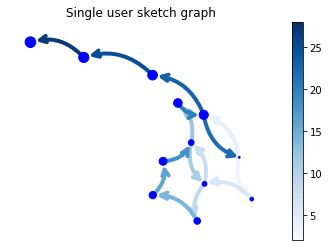

In [11]:
G = all_videos['Help.mp4']['Subject_1']
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [i / M  for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=16,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    connectionstyle="arc3,rad=0.3",
    width=4,
)
# set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)
ax = plt.gca()
ax.set_axis_off()
plt.title('Single user sketch graph')
plt.show()


In [37]:
# Check whether amount of nodes corresponds with the amount of unique views in a data set
lst = []
for i in range(len(coords)):
    lst.append(((coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band']), (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])))

df = pd.DataFrame(lst)
df.columns = ['starts', 'ends']

no_uniques = len(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))
no_nodes = G.number_of_nodes()

print('Valid output:', no_uniques == no_nodes)
print('No of nodes:', no_nodes)
print('No of uniques:', no_uniques)
print(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))

Valid output: True
No of nodes: 8
No of uniques: 8
   starts    ends  count
0  (1, 4)  (2, 1)     19
1  (1, 4)  (3, 1)      2
2  (2, 4)  (3, 1)     11
3  (2, 4)  (3, 2)     86
4  (2, 4)  (4, 1)      5
5  (2, 4)  (4, 2)      2
6  (3, 4)  (4, 1)    486
7  (3, 4)  (4, 2)      3


In [56]:
video_ = {}
for video_id in video_list:
    subj_ = {}
    for subj_id in subject_list:
        G = all_videos[video_id][subj_id]
        subj_[subj_id] = G.number_of_edges() / G.number_of_nodes()

    video_[video_id] = subj_
        # print(subj_id, G.number_of_nodes() / G.number_of_edges())

In [57]:
stat = pd.DataFrame.from_dict(video_)

In [109]:
# stat.sort_index().reset_index(drop=True).to_excel('comparison.xlsx')

In [82]:
stat.mean(axis=1).sort_values(ascending=False)

Subject_10    2.892653
Subject_38    2.801398
Subject_5     2.794554
Subject_29    2.776598
Subject_18    2.768721
Subject_23    2.760790
Subject_35    2.750183
Subject_14    2.734078
Subject_33    2.727268
Subject_3     2.726428
Subject_6     2.698744
Subject_13    2.690037
Subject_12    2.689954
Subject_34    2.681166
Subject_1     2.679953
Subject_37    2.678434
Subject_28    2.672254
Subject_24    2.642469
Subject_21    2.641454
Subject_4     2.630928
Subject_36    2.600749
Subject_19    2.594736
Subject_25    2.579724
Subject_7     2.556715
Subject_39    2.524341
Subject_15    2.505601
Subject_32    2.499950
Subject_31    2.499789
Subject_2     2.494793
Subject_8     2.487448
Subject_27    2.477028
Subject_22    2.459980
Subject_11    2.432443
Subject_17    2.432425
Subject_20    2.397010
Subject_26    2.362704
Subject_30    2.220531
Subject_40    2.184094
Subject_9     2.072741
Subject_16    1.547206
dtype: float64

In [16]:
from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [84]:
replaced = stat
cm = replaced.style.apply(background_gradient, cmap='RdYlGn', m=replaced.min().min(), M=replaced.max().max())


In [84]:
# cm.to_excel('color_comparison_outliers_v3.xlsx')

In [85]:
# f, axes = plt.subplots(8,5, figsize=(24,34))
# names = stat.columns.values.tolist()
# count = 0
# for i in range(8):
#     for j in range(5):
#         stat.boxplot([names[count]], ax=axes[i,j])
#         axes[i,j].set_ylim(1,4.5)
#         count+=1

# f.suptitle('Dynamicity score')
# plt.show()

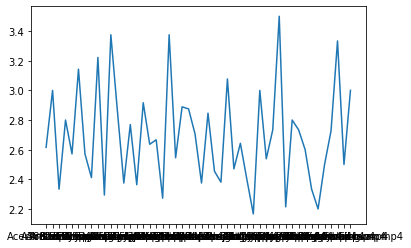

In [91]:
plt.plot(stat.iloc[4])